# Semantic-Question-Matching-Keras

You can download data from: http://qim.ec.quoracdn.net/quora_duplicate_questions.tsv 

Dataset info: https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs 

Blog post about Quora model: https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning

In [1]:
import pandas as pd
from nltk import sent_tokenize, word_tokenize
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils import shuffle
import sqmutils.data_utils as du
import time

%load_ext autoreload
%autoreload 2
%matplotlib inline 
# fix random seed for reproducibility
seed = 7

pathToDataset = "/home/elkhand/datasets/Quora/data/quora_duplicate_questions.tsv"
embedding_path = "/home/elkhand/datasets/glove-vectors/glove.twitter.27B.100d.txt"
train_dataset_path = pathToDataset


Using TensorFlow backend.


## Data exploration

In [2]:
df = pd.read_csv(pathToDataset, sep='\t', encoding='utf-8')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Create train/dev/test set
- train 98%
- dev 1%
- test 1%

In [3]:
# First split dataset into train(99%) and test(1%)
test_size = 0.2
val_size = 0.2
config = du.get_config(train_dataset_path, test_size=test_size, val_size=val_size)
trainDataset, testDataset = du.create_train_test_split(config)

print("\n")

# Second, split train dataset into train (98%) and val (1%) datasets
trainDataset, valDataset = du.create_train_test_split_from_df(trainDataset, config)


print("\n","trainDataset Label distribution: ", trainDataset.groupby('is_duplicate').is_duplicate.count(), "\n")
print("\n","valDataset Label distribution: ", valDataset.groupby('is_duplicate').is_duplicate.count() , "\n")
print("\n","testDataset Label distribution: ", testDataset.groupby('is_duplicate').is_duplicate.count() , "\n")

config
 {'train_dataset_path': '/home/elkhand/datasets/Quora/data/quora_duplicate_questions.tsv', 'val_dataset_path': None, 'test_size': 0.2, 'val_size': 0.2, 'max_seq_len': 40, 'embedding_dimension': 100, 'batch_size': 5000, 'nb_epochs': 100, 'seed': 7, 'is_debug_on': False} 




 trainDataset Label distribution:  is_duplicate
0    163215
1     95528
Name: is_duplicate, dtype: int64 


 valDataset Label distribution:  is_duplicate
0    40804
1    23882
Name: is_duplicate, dtype: int64 


 testDataset Label distribution:  is_duplicate
0    51005
1    29853
Name: is_duplicate, dtype: int64 



In [4]:
trainDataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,219038,83628,98452,Why do I see questions with basic grammatical ...,Do people see questions that are marked as nee...,1
1,319647,78072,89967,Why is there a regulation on the freedom of sp...,Is there freedom of speech on Quora?,1
2,74389,127489,94446,"When Muslims have a baby boy, why do they get ...",How difficult is it for a Hindu boy to marry a...,0
3,64681,112359,112360,Why is the rate of taxes on vehicles so high i...,What is the import duty on vehicles in Nepal?,0
4,289633,410784,348111,What is the real threat to India from being se...,What makes India secular?,0


# Load embeddings

We will be using GloVe twitter 100D

In [5]:
print("word vectors path", embedding_path)
start = time.time()
w2v = du.load_embedding(embedding_path)
end = time.time()
print("Total time passed: ", (end-start))

word vectors path /home/elkhand/datasets/glove-vectors/glove.twitter.27B.100d.txt
embedding size : 1193514
embedding dimension : (100,)
Total time passed:  53.972556829452515


## Set Keras to use Tensorflow GPU in the backend

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from keras import backend as K

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

configProto = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=configProto)
K.set_session(session)

## Train and evaluate model

In [7]:
start = time.time()
df_train_q1_emb,df_train_q2_emb, df_train_label  = du.load_dataset(trainDataset,w2v,config)
df_val_q1_emb,df_val_q2_emb, df_val_label  = du.load_dataset(valDataset,w2v, config)
end = time.time()

print("Total time passed", (end - start))
print("df_train_q1_emb.shape",df_train_q1_emb.shape)
print("df_train_q2_emb.shape", df_train_q2_emb.shape)
print("df_train_label.shape", df_train_label.shape)
    
print("df_val_q1_emb.shape",df_val_q1_emb.shape)
print("df_val_q2_emb.shape", df_val_q2_emb.shape)
print("df_val_label.shape", df_val_label.shape)

Total time passed 76.75089430809021
df_train_q1_emb.shape (258743, 40, 100)
df_train_q2_emb.shape (258743, 40, 100)
df_train_label.shape (258743,)
df_val_q1_emb.shape (64686, 40, 100)
df_val_q2_emb.shape (64686, 40, 100)
df_val_label.shape (64686,)


Total time passed 0.0
df_train_q1_emb.shape (258743, 40, 100)
df_train_q2_emb.shape (258743, 40, 100)
df_train_label.shape (258743,)
df_val_q1_emb.shape (64686, 40, 100)
df_val_q2_emb.shape (64686, 40, 100)
df_val_label.shape (64686,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1_in (InputLayer)              (None, 40, 100)      0                                            
__________________________________________________________________________________________________
q2_in (InputLayer)              (None, 40, 100)      0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 32)           17024       q1_in[0][0]                      
________________________________________________________________________

Epoch 19/100
258743/258743 [==============================] - 14s 53us/step - loss: 0.5213 - acc: 0.7388 - f1: 0.5846 - recall: 0.5017 - precision: 0.7114 - val_loss: 0.5405 - val_acc: 0.7265 - val_f1: 0.5821 - val_recall: 0.5160 - val_precision: 0.6678
Epoch 20/100
258743/258743 [==============================] - 14s 54us/step - loss: 0.5171 - acc: 0.7422 - f1: 0.5922 - recall: 0.5083 - precision: 0.7126 - val_loss: 0.5396 - val_acc: 0.7284 - val_f1: 0.5592 - val_recall: 0.4668 - val_precision: 0.6975
Epoch 21/100
258743/258743 [==============================] - 14s 54us/step - loss: 0.5157 - acc: 0.7433 - f1: 0.5934 - recall: 0.5090 - precision: 0.7156 - val_loss: 0.5382 - val_acc: 0.7288 - val_f1: 0.5717 - val_recall: 0.4903 - val_precision: 0.6857
Epoch 22/100
258743/258743 [==============================] - 14s 53us/step - loss: 0.5149 - acc: 0.7435 - f1: 0.5942 - recall: 0.5113 - precision: 0.7165 - val_loss: 0.5388 - val_acc: 0.7288 - val_f1: 0.5743 - val_recall: 0.4957 - val_pr

Epoch 51/100
258743/258743 [==============================] - 14s 53us/step - loss: 0.4806 - acc: 0.7660 - f1: 0.6348 - recall: 0.5513 - precision: 0.7486 - val_loss: 0.5352 - val_acc: 0.7380 - val_f1: 0.5898 - val_recall: 0.5103 - val_precision: 0.6989
Epoch 52/100
258743/258743 [==============================] - 14s 53us/step - loss: 0.4804 - acc: 0.7662 - f1: 0.6359 - recall: 0.5531 - precision: 0.7482 - val_loss: 0.5350 - val_acc: 0.7387 - val_f1: 0.5887 - val_recall: 0.5066 - val_precision: 0.7027
Epoch 53/100
258743/258743 [==============================] - 14s 53us/step - loss: 0.4803 - acc: 0.7660 - f1: 0.6355 - recall: 0.5527 - precision: 0.7481 - val_loss: 0.5364 - val_acc: 0.7369 - val_f1: 0.5929 - val_recall: 0.5189 - val_precision: 0.6915
Epoch 54/100
258743/258743 [==============================] - 14s 53us/step - loss: 0.4801 - acc: 0.7662 - f1: 0.6359 - recall: 0.5531 - precision: 0.7481 - val_loss: 0.5366 - val_acc: 0.7381 - val_f1: 0.5901 - val_recall: 0.5108 - val_pr

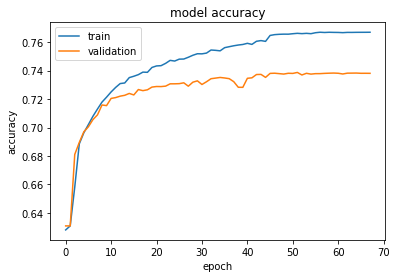

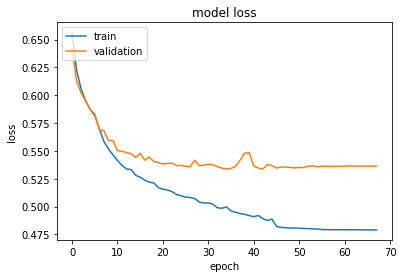

In [8]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense
from keras.layers import GRU, Bidirectional
from keras.layers.core import Dropout
from keras.layers.core import Masking
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import keras
from keras.layers import multiply

from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model



def _build_model(config):
    input1 = keras.layers.Input(shape=(config["max_seq_len"],config["embedding_dimension"], ), name='q1_in')
    x1 = LSTM(32, name='LSTM1')(input1)
    input2 = keras.layers.Input(shape=(config["max_seq_len"],config["embedding_dimension"], ), name='q2_in')
    x2 = LSTM(32, name='LSTM2')(input2)
    # Equivalent to subtracted = keras.layers.subtract([x1, x2])
    subtracted = keras.layers.Subtract()([x1, x2])
    mult = multiply([x1, x2])
    dotProduct = keras.layers.dot([x1, x2], axes = -1,  normalize=False)
    concatenate = keras.layers.concatenate([x1,x2, subtracted, mult, dotProduct], axis=-1)
    dense1 = Dense(8, activation='relu', name='dense1')(concatenate)
    dense2 = Dense(8, activation='relu', name='dense2')(dense1)
    output = Dense(1, activation='sigmoid', name='output')(dense2)
    model = Model(inputs=[input1, input2], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy', du.f1, du.recall, du.precision])
    model.summary()
    return model


def train_model():
    start = time.time()
    #df_train_q1_emb,df_train_q2_emb, df_train_label  = du.load_dataset(trainDataset,w2v,config)
    #df_val_q1_emb,df_val_q2_emb, df_val_label  = du.load_dataset(valDataset,w2v, config)
    end = time.time()
    print("Total time passed", (end - start))
    print("df_train_q1_emb.shape",df_train_q1_emb.shape)
    print("df_train_q2_emb.shape", df_train_q2_emb.shape)
    print("df_train_label.shape", df_train_label.shape)
    
    print("df_val_q1_emb.shape",df_val_q1_emb.shape)
    print("df_val_q2_emb.shape", df_val_q2_emb.shape)
    print("df_val_label.shape", df_val_label.shape)
    model = _build_model(config)
    
    reduce_lr = ReduceLROnPlateau(#monitor='val_loss', 
                                  #factor=0.2, 
                                  #patience=5, 
                                  #min_lr=0.001,
                                  verbose=1)
    
    #filepath="model/adidas-may-29.h5"
    #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=25)#10
    callback_list = [reduce_lr, early_stopping] # , early_stopping
    #config['nb_epochs'] = 10
    history = model.fit(x=[df_train_q1_emb, df_train_q2_emb],
                  y=df_train_label, 
                  batch_size=config['batch_size'], 
                  epochs=config['nb_epochs'], 
                  verbose=1, 
                  validation_data = ([df_val_q1_emb,df_val_q2_emb], df_val_label),
                  callbacks=callback_list)#
    return history 

start = time.time()
history = train_model() 
end = time.time()
print("Total time", (end - start))
du.plot_model_accuracy(history,modelDir="models/", hasF1=True)

## [OLD] Train and evaluate model

In [9]:
# def _build_model(num_of_classes, config): 
#     model = Sequential()
#     model.add(Masking(mask_value=0., input_shape=(None, config['embedding_dimension'])))
#     model.add(Bidirectional(GRU(config['hidden_layer_dim'], return_sequences=True, \
#                 dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout']), merge_mode='concat'))
#     model.add(Bidirectional(GRU(config['hidden_layer_dim'], dropout=config['dropout'],\
#                                 recurrent_dropout=config['recurrent_dropout']), merge_mode='concat'))
#     model.add(Dense(num_of_classes, activation='softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model
       
# def train_model(X_train, y_train, X_val, y_val, num_of_classes, config):
#     print('X_train shape : %s' % (X_train.shape,))
#     print('y_train shape : %s' % (y_train.shape,))
#     print('X_val shape : %s' % (X_val.shape,))
#     print('y_val shape : %s' % (y_val.shape,))
#     print('number of classes : %d' % num_of_classes) 
#     model = _build_model(num_of_classes, config)
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                                   factor=0.2, 
#                                   patience=5, 
#                                   min_lr=0.001)
#     # checkpoint
#     filepath="model/adidas-may-29.h5"
#     checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
#     early_stopping = EarlyStopping(monitor='val_loss', patience=25)#10
#     callback_list = [reduce_lr, checkpoint] # , early_stopping
#     history = model.fit(x=X_train,
#                   y=y_train, 
#                   batch_size=config['batch_size'], 
#                   epochs=config['nb_epochs'], 
#                   verbose=1, 
#                   validation_data = (X_val, y_val),
#                   shuffle=True,
#                   callbacks=callback_list)#
    
#     val_acc_list = history.history['val_acc']
#     best_val_acc =  max(val_acc_list)
#     filename = "intent" 
#     filename = "model/" + dt.generate_model_name(filename, best_val_acc) + ".h5"
#     os.rename(filepath, filename)
#     return history

# def train_helper(dfTrain, dfVal, config, shouldShuffleTrainDataset=True):
# #     class_to_index = {}
# #     index_to_class = {}
# #     dfTrain = shuffle(dfTrain)
# #     X_train, y_train_index, num_of_classes, class_to_index, index_to_class = dt.load_dataset_StratifiedKFold(dfTrain, w2v, config, class_to_index, index_to_class)
# #     y_train = dt.convert_index_to_one_hot(y_train_index, num_of_classes) 
        
# #     print("dfTrain.head(10) \n", dfTrain.head(10))
# #     print("dfTrain.tail(10) \n", dfTrain.tail(10))
# #     print("\n","Train label distribution: \n",dfTrain.groupby('label').label.count())
# #         print("num_of_classes", num_of_classes)
# #         print("class_to_index", class_to_index)
# #         print("index_to_class", index_to_class)
        
# #     print("dfVal.head(10)",dfVal.head(10))
# #     print("dfVal.tail(10)",dfVal.tail(10))
        
# #     X_val, y_val_index, _, _, _ = dt.load_dataset_StratifiedKFold(dfVal, w2v, config, class_to_index, index_to_class)
# #     y_val = dt.convert_index_to_one_hot(y_val_index, num_of_classes) 
# #     print("\n","Val label distribution: ",dfVal.groupby('label').label.count())
        
#     # Train model
#     history = train_model(X_train, y_train, X_val, y_val, num_of_classes, config)
#     val_acc_list = history.history['val_acc']
#     best_val_acc =  max(val_acc_list)
#     return [history, best_val_acc]


# def predict(w2v):
#     model = keras.models.load_model('model/intent_model_ricodataset.h5')
#     sentence = "www.google.com"
#     X_train = []
#     X_train.append(get_sequence_embedding(sentence.split(" "),w2v, max_seq_len))
#     X_train = np.array(X_train)
#     print(X_train.shape)
#     result = model.predict(X_train)
#     print(result)
#     print(index_to_class)
#     for i in index_to_class:
#         print("%s : %.3f%%" % (index_to_class[i], result[0][i] * 100))

# def text_pre_processing(document):
#     document = text.text_to_word_sequence(document, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')
#     print(document)
#     return document


# def get_config():
#     conf = {}
#     conf["embedding_dimension"] = 100# 300 #100
#     conf["max_seq_len"] = 40
#     conf["dropout"] = 0.3
#     conf["recurrent_dropout"] = 0.3
#     conf["hidden_layer_dim"] = 40
#     conf["batch_size"] = 40
#     conf["nb_epochs"] = 100 #300
#     print("config\n",conf,"\n")
#     return conf
    

# def main():
#     config = get_config()
#     if w2v is not None:
#         print('embedding size : %d' % len(w2v))
#         print('embedding dimension : %s' % (w2v['apple'].shape,))
#         print("Sample words from word2vec: ", list(w2v.keys())[:10], list(w2v.keys())[-10:])
# #         history, best_val_acc = train_helper(dfTrain, dfVal, config)
# #         pt.plot_model_accuracy(history,"model/", isF1Enabled)
# #         print("best_val_acc",best_val_acc)
#     # predict()
#     # text_pre_processing("hello&nbsp;hi")

# if __name__ == "__main__":
#     # execute only if run as a script
#     main()